# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [31]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

2.371661899579992
loss: 2.371662
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ With randomly initialized weights, the score for the correct class of each training example should be the same as any other class on average. Since sum(P(classes)) = 1, the average score for the each class (including the correct class) should be 0.1. The loss of each training example is -log(score) on average, so the average loss across all training examples should be -log(0.1).



In [37]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print("---")

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.385567 analytic: 1.385567, relative error: 2.250012e-09
numerical: -0.096886 analytic: -0.096886, relative error: 2.133426e-08
numerical: -0.097751 analytic: -0.097751, relative error: 1.245716e-07
numerical: -3.761506 analytic: -3.761506, relative error: 1.210007e-08
numerical: -0.937699 analytic: -0.937699, relative error: 3.994082e-08
numerical: 3.552780 analytic: 3.552780, relative error: 1.636368e-08
numerical: 0.810635 analytic: 0.810635, relative error: 3.319031e-08
numerical: -1.185172 analytic: -1.185172, relative error: 3.746084e-08
numerical: 2.584271 analytic: 2.584271, relative error: 1.252261e-08
numerical: -0.795023 analytic: -0.795023, relative error: 4.170967e-08
---
numerical: 0.224777 analytic: 0.224777, relative error: 1.499743e-07
numerical: 0.212453 analytic: 0.212453, relative error: 5.936027e-08
numerical: 0.326446 analytic: 0.326445, relative error: 5.913191e-08
numerical: -0.035265 analytic: -0.035265, relative error: 1.189930e-06
numerical: 2.756

In [70]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.371662e+00 computed in 0.228005s
vectorized loss: 2.371662e+00 computed in 0.003022s
Loss difference: 0.000000
Gradient difference: 0.000000


In [75]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 3e-7]
regularization_strengths = [1e4, 3e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for rate in learning_rates:
    for strength in regularization_strengths:
        sm = Softmax()
        loss_hist = sm.train(X_train, y_train, learning_rate=rate, reg=strength,
                      num_iters=1000, verbose=True)
        y_train_pred = sm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = sm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print(train_accuracy)
        print(val_accuracy)
        print()
        results[(rate, strength)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = sm
        # print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 309.712345
iteration 100 / 1000: loss 206.885799
iteration 200 / 1000: loss 138.720511
iteration 300 / 1000: loss 93.414444
iteration 400 / 1000: loss 63.004998
iteration 500 / 1000: loss 42.835147
iteration 600 / 1000: loss 29.415633
iteration 700 / 1000: loss 20.317187
iteration 800 / 1000: loss 14.206049
iteration 900 / 1000: loss 10.215422
0.335
0.352

iteration 0 / 1000: loss 930.657914
iteration 100 / 1000: loss 279.430430
iteration 200 / 1000: loss 85.066361
iteration 300 / 1000: loss 26.909877
iteration 400 / 1000: loss 9.511664
iteration 500 / 1000: loss 4.293525
iteration 600 / 1000: loss 2.749701
iteration 700 / 1000: loss 2.302191
iteration 800 / 1000: loss 2.147707
iteration 900 / 1000: loss 2.127356
0.32126530612244897
0.333

iteration 0 / 1000: loss 316.122191
iteration 100 / 1000: loss 95.094138
iteration 200 / 1000: loss 29.718858
iteration 300 / 1000: loss 10.283023
iteration 400 / 1000: loss 4.540744
iteration 500 / 1000: loss 2.756230
iterat

In [77]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.358000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Yes

$\color{blue}{\textit Your Explanation:}$ The softmax loss of any datapoint cannot be zero, as that would require the score of the correct class to be positive infinity and the scores of the incorrect class to be negative infinity (thus creating P(correct_class) = 1 and P(other_classes) = 0). However, the SVM loss of a datapoint can be zero, as long as the scores of every incorrect class for the datapoint are at least a certain margin below the score of the correct class.


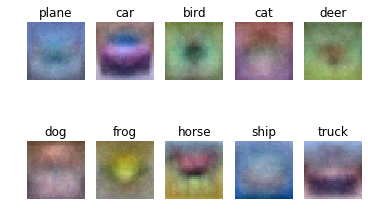

In [78]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])